In [2]:



import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pywrdrb.utils.hdf5 import extract_realization_from_hdf5
from pywrdrb.utils.hdf5 import get_hdf5_realization_numbers

from sglib.utils.load import load_drb_reconstruction
from sglib.droughts.ssi import SSIDroughtMetrics
from config import gage_flow_ensemble_fname, catchment_inflow_ensemble_fname
from config import FIG_DIR

In [3]:
### Loading data
## Historic reconstruction data
# Total flow
Q = load_drb_reconstruction()
Q.replace(0, np.nan, inplace=True)
Q.drop(columns=['delTrenton'], inplace=True)  # Remove Trenton gage as it is not used in the ensemble

# Catchment inflows
Q_inflows = load_drb_reconstruction(gage_flow=False)
Q_inflows.replace(0, np.nan, inplace=True)
Q_inflows.drop(columns=['delTrenton'], inplace=True)  # Remove Trenton gage as it is not used in the ensemble

print(f"Loaded reconstruction data with {Q.shape[0]// 365} years of daily data for {Q.shape[1]} sites.")

Q_monthly = Q.resample('MS').sum()

Loaded reconstruction data with 79 years of daily data for 30 sites.


In [4]:
## Synthetic ensemble
realization_ids = get_hdf5_realization_numbers(gage_flow_ensemble_fname)
n_realizations = len(realization_ids)

syn_ensemble = {}
inflow_ensemble = {}
for i in realization_ids:
    # Extract realization data
    df = extract_realization_from_hdf5(
        gage_flow_ensemble_fname, i, 
        stored_by_node=True)
    df.drop(columns=['datetime', 'delTrenton'], inplace=True)
    syn_ensemble[i] = df
    
    df = extract_realization_from_hdf5(
        catchment_inflow_ensemble_fname, i,
        stored_by_node=True)
    df.drop(columns=['datetime', 'delTrenton'], inplace=True)
    inflow_ensemble[i] = df
    
# Make a second copy of each with sites as keys
Q_syn = {}
Qs_inflows = {}
syn_datetime = syn_ensemble[realization_ids[0]].index
for site in syn_ensemble[realization_ids[0]].columns:
    if site == 'datetime':
        continue
    
    Q_syn[site] = np.zeros((len(syn_datetime), n_realizations),
                 dtype=float)
    Qs_inflows[site] = np.zeros((len(syn_datetime), n_realizations),
                    dtype=float)
    
    
    for i in realization_ids:
        # print(f"Processing realization {i} for site {site}")
        # print(f"Columns in syn_ensemble[{i}]: {syn_ensemble[i].columns}")
        
        Q_syn[site][:, int(i)] = syn_ensemble[i][site].values 
        Qs_inflows[site][:, int(i)] = inflow_ensemble[i][site].values
            
    # Convert to DataFrame
    Q_syn[site] = pd.DataFrame(Q_syn[site], 
                               index=syn_datetime, 
                               columns=[i for i in range(n_realizations)])
    Qs_inflows[site] = pd.DataFrame(Qs_inflows[site],
                                    index=syn_datetime, 
                                    columns=[i for i in range(n_realizations)])

In [31]:
Q_syn[plot_site].index

DatetimeIndex(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
               '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
               '1970-01-09', '1970-01-10',
               ...
               '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
               '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30',
               '2019-12-31', '2020-01-01'],
              dtype='datetime64[ns]', length=18263, freq=None)

In [ ]:
plot_site = 'delMontague'
Qh = Q.loc[:,[plot_site]]
Qs = Q_syn[plot_site]
timescale = 'monthly'  # or 'weekly'


# Input validation and conversion
if isinstance(Qh, pd.Series):
    Qh = Qh.to_frame(name='flow')
elif isinstance(Qh, pd.DataFrame):
    if Qh.shape[1] != 1:
        raise ValueError("Qh DataFrame must have exactly one column.")
    Qh.columns = ['flow']  # Standardize column name
else:
    raise ValueError("Qh must be a pandas Series or single-column DataFrame with datetime index.")

if not isinstance(Qs, pd.DataFrame):
    raise ValueError("Qs must be a pandas DataFrame with datetime index and multiple columns.")

# Check datetime indices
if not isinstance(Qh.index, pd.DatetimeIndex):
    raise ValueError("Qh must have a datetime index.")
if not isinstance(Qs.index, pd.DatetimeIndex):
    raise ValueError("Qs must have a datetime index.")

# Aggregate the data based on the specified timescale
if timescale == 'monthly':
    Qh_agg = Qh.resample('MS').sum()
    Qs_agg = Qs.resample('MS').sum()
    n_periods = 12
    period_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
elif timescale == 'weekly':
    Qh_agg = Qh.resample('W').sum()
    Qs_agg = Qs.resample('W').sum()
    n_periods = 52
    period_labels = [str(x) if x % 4 == 1 else '' for x in range(1, 53)]
else:
    raise ValueError("Invalid timescale. Choose from 'monthly' or 'weekly'.")

# Add period and year columns
if timescale == 'monthly':
    Qh_agg['period'] = Qh_agg.index.month
    Qs_agg['period'] = Qs_agg.index.month
elif timescale == 'weekly':
    Qh_agg['period'] = Qh_agg.index.isocalendar().week
    Qs_agg['period'] = Qs_agg.index.isocalendar().week

Qh_agg['year'] = Qh_agg.index.year
Qs_agg['year'] = Qs_agg.index.year

# Reshape data into arrays
# Shapes should be:
# Qs_array: (n_realizations, n_periods, n_syn_years)
# Qh_array: (n_realizations, n_periods, n_hist_years)
# where Qh_array is resampled to create n_realizations of sampled data
n_syn_years = len(Qs_agg['year'].unique())
n_hist_years = len(Qh_agg['year'].unique())

Qs_array = np.zeros((n_realizations, n_periods, n_syn_years), dtype=float)
Qh_array = np.zeros((n_realizations, n_periods, n_hist_years), dtype=float)

for i in range(n_realizations):
    for j in range(n_periods):
        # Get the period data for each realization
        Qs_array[i, j, :] = Qs_agg[Qs_agg['period'] == j + 1].iloc[:, i].values
        
        # get random sample from historical year
        random_year = np.random.choice(Qh_agg['year'].unique())
        Qh_array[i, j, :] = Qh_agg[Qh_agg['period'] == j + 1][
            Qh_agg['year'] == random_year].iloc[:, 0].values

C:\Users\tjame\AppData\Local\Temp\ipykernel_35296\75773211.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Qh_array[i, j, :] = Qh_agg[Qh_agg['period'] == j + 1][


ValueError: could not broadcast input array from shape (50,) into shape (51,)

In [30]:
Qs_agg[Qs_agg['period'] == 10].iloc[:, 1].index


DatetimeIndex(['1970-10-01', '1971-10-01', '1972-10-01', '1973-10-01',
               '1974-10-01', '1975-10-01', '1976-10-01', '1977-10-01',
               '1978-10-01', '1979-10-01', '1980-10-01', '1981-10-01',
               '1982-10-01', '1983-10-01', '1984-10-01', '1985-10-01',
               '1986-10-01', '1987-10-01', '1988-10-01', '1989-10-01',
               '1990-10-01', '1991-10-01', '1992-10-01', '1993-10-01',
               '1994-10-01', '1995-10-01', '1996-10-01', '1997-10-01',
               '1998-10-01', '1999-10-01', '2000-10-01', '2001-10-01',
               '2002-10-01', '2003-10-01', '2004-10-01', '2005-10-01',
               '2006-10-01', '2007-10-01', '2008-10-01', '2009-10-01',
               '2010-10-01', '2011-10-01', '2012-10-01', '2013-10-01',
               '2014-10-01', '2015-10-01', '2016-10-01', '2017-10-01',
               '2018-10-01', '2019-10-01'],
              dtype='datetime64[ns]', freq='12MS')

In [14]:
len(Qs_flows)

12

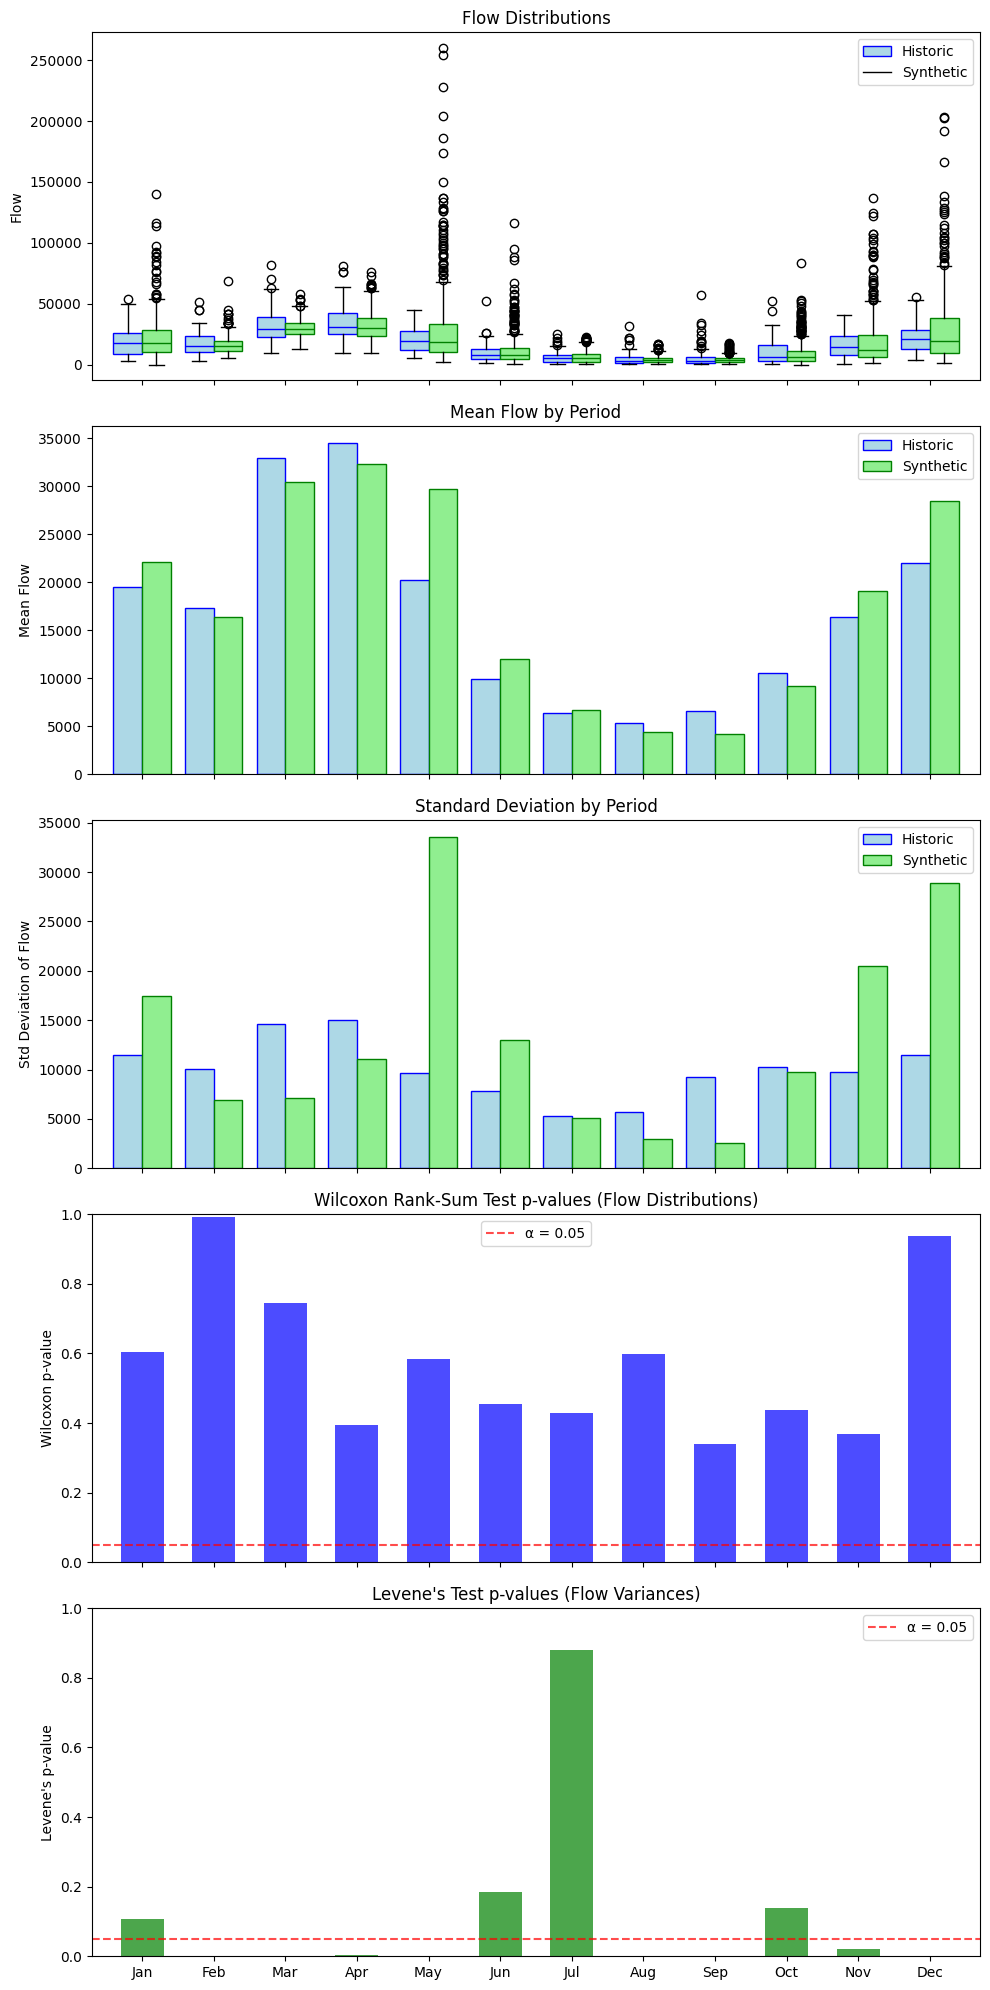

In [4]:
from sglib.plotting.monthly_flow_statistics import plot_statistical_flow_test

fig, axs = plot_statistical_flow_test(Q.loc[:, ['cannonsville']], Q_syn['cannonsville'], timescale='monthly',)